<a href="https://colab.research.google.com/github/Vladislav-GitHub/VK_internship/blob/main/VK_Inernship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Загрузка, распаковка файлов и импорт необходимых бибилиотек

In [1]:
!wget 'https://files.grouplens.org/datasets/movielens/ml-latest.zip'

--2023-05-10 16:48:24--  https://files.grouplens.org/datasets/movielens/ml-latest.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 277113433 (264M) [application/zip]
Saving to: ‘ml-latest.zip.1’

ml-latest.zip.1     100%[===================>] 264.28M  12.4MB/s    in 21s     

2023-05-10 16:48:46 (12.4 MB/s) - ‘ml-latest.zip.1’ saved [277113433/277113433]



In [ ]:
!unzip 'ml-latest.zip'

In [ ]:
!pip install pytorch-lightning
!pip install torchtext

In [4]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

#Пример моей схемы БД

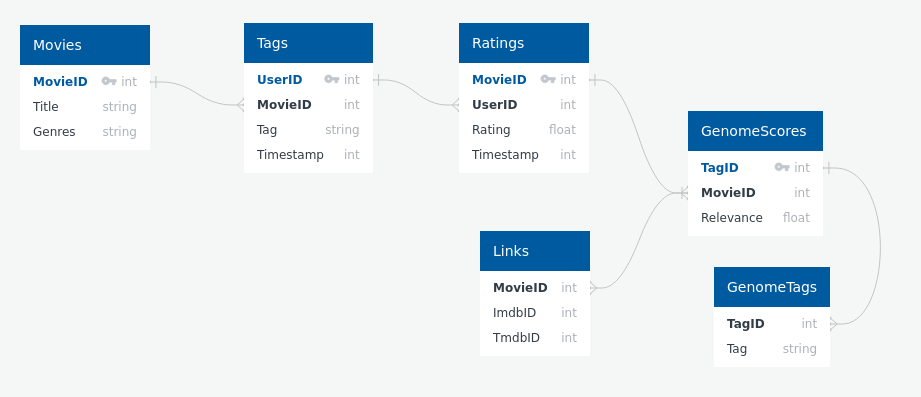

Изначально я пытался объединить все файлы в один преобразуя в SQL формат при помощи создания БД в SQLite и некоторых запросов, однако не вышло из-за нехватки оперативной памяти.
Потом попробовал смержить их разными способами, одним вышло, однако посмотрев на данные и в целом на задачу, решил изменить свой подход к решению (попытки оставил внизу под решением).

#Предобработка данных

In [5]:
ratings = pd.read_csv('/content/ml-latest/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


Использовать буду данные только от 25% случайных пользователей в этом наборе данных.

In [6]:
random_userIds = np.random.choice(ratings['userId'].unique(), 
                                size=int(len(ratings['userId'].unique())*0.25), 
                                replace=False)

ratings = ratings.loc[ratings['userId'].isin(random_userIds)]
print(f'Выделилось {len(ratings)} строк из общего количества рейтингов пользователей = {len(random_userIds)}')

Выделилось 6936855 строк из общего количества рейтингов пользователей = 70807


#Разбиение данных на обучение и валидацию

In [7]:
ratings['rank_last'] = ratings.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)

train_ratings = ratings[ratings['rank_last'] != 1]
test_ratings = ratings[ratings['rank_last'] == 1]

train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

Предсказание, будет ли пользователь взаимодействовать с каждым фильмом (т.е. выполнять некое действие), чтобы представлять пользователям фильмы с наибольшей вероятностью взаимодействия

In [8]:
train_ratings.loc[:, 'rating'] = 1
train_ratings.sample(5)

,userId,movieId,rating
8106009,83444,1197,1
1420235,14368,105504,1
12185499,124818,29,1
16785681,171661,2469,1
12727293,130301,1291,1


In [ ]:
# Уникальные id фильмов
all_movieIds = ratings['movieId'].unique()

users = []
items = []
labels = []

# Множество с которым взаимодействует каждый пользователь
user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

# 4:1 коэффициент отношения негативных к положительным выборкам
coeff = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1)
    
    for _ in range(coeff):
        # Случайно выберем id
        negative_item = np.random.choice(all_movieIds) 

        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0)

  0%|          | 0/6866048 [00:00<?, ?it/s]

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [10]:
class TrainDataset(Dataset):

    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        users = []
        items = []
        labels = []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))
        coeff = 4

        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)

            for _ in range(coeff):
                negative_item = np.random.choice(all_movieIds)

                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)
        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

Фильтрующий метод глубокого машинного обучения, разработанный и расммотренный в статье [Neural Collaborative Filtering](https://arxiv.org/abs/1708.05031), который использует 2 Embedding слоя, один для пользователей, другой для фильмов. Далее после этих слоёв 2 полученных вектора конкатенируются в 1 вектор и пройдя череду полносвязных слоёв с ф-цией активации ReLU, определяются финальным слоём с помощью сигмоиды либо как положительный класс 1, либо как отрицательный класс 0.

In [11]:
class Filtering(pl.LightningModule):
    
    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds
        
    def forward(self, user_input, item_input):
        
        # Слои векторных представлений
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Конкатенация этих слоёв в единый вектор
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Полносвязные слои с ф-цией активации ReLU
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Выходной слой
        pred = nn.Sigmoid()(self.output(vector))
        return pred
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(TrainDataset(self.ratings, self.all_movieIds),
                          batch_size=512, num_workers=4)

In [12]:
num_users = ratings['userId'].max() + 1
num_items = ratings['movieId'].max() + 1
all_movieIds = ratings['movieId'].unique()
model = Filtering(num_users, num_items, train_ratings, all_movieIds)

In [13]:
gpu_available = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_available}")

Is the GPU available? True


Одно из преимуществ PyTorch Lightning заключается в том, что не нужно писать собственный обучающий шаблон. Гораздо проще использовать класс Trainer для обучения модели.

In [14]:
trainer = pl.Trainer(max_epochs=5,
                     accelerator='auto',
                     reload_dataloaders_every_n_epochs=1,
                     logger=False)
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.3 M 
1 | item_embedding | Embedding | 1.6 M 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
3.8 M     Trainable params
0         Non-trainable params
3.8 M     Total params
15.280    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Чтобы создать список из 10 рекомендуемых элементов (фильмов) для каждого пользователя:

    - Для каждого пользователя случайным образом выберем 99 элементов, с которыми пользователь не взаимодействовал.
    - Объединим эти 99 элемента с тестовым элементом (фактический элемент, с которым взаимодействовал пользователь). Теперь у нас есть 100 элементов.
    - Запустим модель на этих 100 элементах и ​​ранжируем их в соответствии с их предсказанными вероятностями.
    - Выбираем 10 лучших элементов из списка из 100 элементов. Если тестовый элемент присутствует в топ-10, то мы говорим, что это попадание (Hit).
    - Повторяем процесс для всех пользователей. Коэффициент попаданий — это среднее количество попаданий.

Эта метрика известна как Hit Ratio@10 и обычно используется для оценки рекомендательных систем.

In [15]:
test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))
user_interacted_items = ratings.groupby('userId')['movieId'].apply(list).to_dict()
hits = []

for (u, i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]  
    predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
                                        torch.tensor(test_items)).detach().numpy())    
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)
        
print("The Hit Ratio@10 = {:.3f}".format(np.average(hits)))

  0%|          | 0/70807 [00:00<?, ?it/s]

The Hit Ratio@10 = 0.914


---

#Изначальные попытки

In [ ]:
import sqlite3
import re
import glob

In [ ]:
# file_path = "/content/ml-latest"
# file_list = os.listdir(file_path)
#csv_list = [l for l in map(lambda l: re.findall(r'[a-zA-Z]+.csv', l), file_list) if l != []]
csv_files = glob.glob('/content/ml-latest/*.csv')
csv_files

['/content/ml-latest/movies.csv',
 '/content/ml-latest/links.csv',
 '/content/ml-latest/ratings.csv',
 '/content/ml-latest/genome-scores.csv',
 '/content/ml-latest/genome-tags.csv',
 '/content/ml-latest/tags.csv']

In [ ]:
data = pd.DataFrame()

for file in csv_files:
  df_temp = pd.read_csv(file)
  data = data.append(df_temp, ignore_index=True)

data.sample(5)

,movieId,title,genres,imdbId,tmdbId,userId,rating,timestamp,tagId,relevance,tag
32653431,4708.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1072.0,0.22625,NaN
14826958,5349.0,NaN,NaN,NaN,NaN,150474.0,4.5,1.159811e+09,NaN,NaN,NaN
20731516,8464.0,NaN,NaN,NaN,NaN,210540.0,5.0,1.113857e+09,NaN,NaN,NaN
39892843,88301.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,980.0,0.05650,NaN
6594359,6373.0,NaN,NaN,NaN,NaN,66550.0,2.5,1.276640e+09,NaN,NaN,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43842293 entries, 0 to 43842292
Data columns (total 11 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    float64
 1   title      object 
 2   genres     object 
 3   imdbId     float64
 4   tmdbId     float64
 5   userId     float64
 6   rating     float64
 7   timestamp  float64
 8   tagId      float64
 9   relevance  float64
 10  tag        object 
dtypes: float64(8), object(3)
memory usage: 3.6+ GB


In [ ]:
data = data.drop(['movieId', 'tagId', 'userId'], axis=1)

In [ ]:
data.isna().sum()

title        43784195
genres       43784195
imdbId       43784195
tmdbId       43784376
rating       16088849
timestamp    14979852
relevance    28979765
tag          42732184
dtype: int64

In [ ]:
data.drop_na()

In [ ]:
data.astype({'movieId': np.int32, 'imdbId': np.int32, 'tmdbId': np.int32,
             'userId': np.int32, 'tagId': np.int32}).dtypes

Преобразования в SQL формат при помощи создания БД в SQLite и создание некоторых запросов

In [ ]:
movies = pd.read_csv('/content/ml-latest/movies.csv')
tags = pd.read_csv('/content/ml-latest/tags.csv')
ratings = pd.read_csv('/content/ml-latest/ratings.csv')
links = pd.read_csv('/content/ml-latest/links.csv')
genome_scores = pd.read_csv('/content/ml-latest/genome-scores.csv')
genome_tags = pd.read_csv('/content/ml-latest/genome-tags.csv')

In [ ]:
conn = sqlite3.connect('database.db')
conn = sqlite3.connect(':memory:')

c = conn.cursor()

c.execute('CREATE TABLE IF NOT EXISTS movies (movieID int, title string, genres string)')
c.execute('CREATE TABLE IF NOT EXISTS tags (userID int, movieID int, tag string, timestamp int)')
c.execute('CREATE TABLE IF NOT EXISTS ratings (userID int, movieID int, rating string, timestamp int)')
c.execute('CREATE TABLE IF NOT EXISTS links (movieID int, imdbID int, tmdbID int)')
c.execute('CREATE TABLE IF NOT EXISTS genome_scores (movieID int, tagID int, relevance float)')
c.execute('CREATE TABLE IF NOT EXISTS genome_tags (tagID int, tag string)')

conn.commit()

movies.to_sql('movies', conn, if_exists='replace', index=False)
tags.to_sql('tags', conn, if_exists='replace', index=False)
ratings.to_sql('ratings', conn, if_exists='replace', index=False)
links.to_sql('links', conn, if_exists='replace', index=False)
genome_scores.to_sql('genome_scores', conn, if_exists='replace', index=False)
genome_tags.to_sql('genome_tags', conn, if_exists='replace', index=False)

c.execute('''
		SELECT title, genres, tag, timestamp, relevance, imdbID, tmdbID, rating FROM movies
    JOIN tags ON movies.movieID = tags.movieID
    JOIN genome_scores gs ON ratings.movieID = gs.movieID
    JOIN links ON gs.movieID = links.movieID
    JOIN genome_tags gt ON gs.tagID = gt.tagID;
          ''')

In [ ]:
data = pd.DataFrame(c.fetchall(), columns=['title', 'genres', 'tag', 'timestamp', 'relevance', 'imdbID', 'tmdbID', 'rating'])
conn.close()

In [ ]:
data.head()

,title,genres,tag,timestamp
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2009 reissue in Stereoscopic 3-D,1306611568
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3D,1173686898
2,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3D,1273665163
3,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3D,1385395898
4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,55 movies every kid should see--Entertainment ...,1407082526


Серия мержей (Full Outer Joins)

In [ ]:
df_1 = movies.merge(tags,
                   on = 'movieId', 
                   how = 'outer')

df_2 = df_1.merge(ratings,
                   on = 'userId', 
                   how = 'outer')

df_3 = df_2.merge(genome_scores,
                   on = 'movieId', 
                   how = 'outer')

df_4 = df_3.merge(genome_tags,
                   on = 'tagId', 
                   how = 'outer')

data = df_4.merge(links,
                   on = 'movieId', 
                   how = 'outer')

data.head()